In [1]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [4]:
df = pd.read_csv('Downloads/GermanCredit.csv')

df.head()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,... < 100 DM,6,critical account/other credits existing,domestic appliances,1169,unknown/no savings account,... >= 7 years,4,male : single,none,...,real estate,67,none,own,2,skilled employee/official,1,yes,yes,1
1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,none,...,real estate,22,none,own,1,skilled employee/official,1,no,yes,0
2,no checking account,12,critical account/other credits existing,retraining,2096,... < 100 DM,4 <= ... < 7 years,2,male : single,none,...,real estate,49,none,own,1,unskilled - resident,2,no,yes,1
3,... < 100 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,guarantor,...,building society savings agreement/life insurance,45,none,for free,1,skilled employee/official,2,no,yes,1
4,... < 100 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,none,...,unknown/no property,53,none,for free,2,skilled employee/official,2,no,yes,0


In [7]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

In [9]:
for col in categorical_cols:
    print(f"\n▶ {col} ({df[col].nunique()} categories):")
    print(df[col].value_counts())


▶ status (4 categories):
no checking account                           394
... < 100 DM                                  274
0 <= ... < 200 DM                             269
... >= 200 DM / salary for at least 1 year     63
Name: status, dtype: int64

▶ credit_history (5 categories):
existing credits paid back duly till now       530
critical account/other credits existing        293
delay in paying off in the past                 88
all credits at this bank paid back duly         49
no credits taken/all credits paid back duly     40
Name: credit_history, dtype: int64

▶ purpose (10 categories):
domestic appliances    280
car (new)              234
radio/television       181
car (used)             103
others                  97
retraining              50
education               22
repairs                 12
furniture/equipment     12
business                 9
Name: purpose, dtype: int64

▶ savings (5 categories):
... < 100 DM                  603
unknown/no savings account    183
10

In [11]:
def split_personal_status(value):
    if value.startswith('male'):
        sex = 'male'
    else:
        sex = 'female'
    
    status = value.split(":")[-1].strip()
    return pd.Series([sex, status])

# Apply and replace
df[['Sex', 'Personal_Status']] = df['personal_status_sex'].apply(split_personal_status)

# Drop the original column
df.drop(columns='personal_status_sex', inplace=True)

In [13]:
df['foreign_worker'] = df['foreign_worker'].map({'yes': 1, 'no': 0})

# Map 'telephone' to binary: yes → 1, no → 0
df['telephone'] = df['telephone'].map({'yes': 1, 'no': 0})

In [15]:
df.drop(columns='Personal_Status', inplace=True)

In [17]:
df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})

In [19]:
exclude_cols = ['people_liable', 'telephone', 'foreign_worker', 'credit_risk', 'Sex']

In [21]:
numerical_cols_for_outliers = df.select_dtypes(include=['int64', 'float64']).columns
numerical_cols_for_outliers = [col for col in numerical_cols_for_outliers if col not in exclude_cols]

# Function to cap outliers using IQR
def cap_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

# Apply capping only to the valid features
for col in numerical_cols_for_outliers:
    cap_outliers_iqr(df, col)

In [23]:
status_mapping = {
    "... < 100 DM": "lt_100",
    "0 <= ... < 200 DM": "btw_0_200",
    "... >= 200 DM / salary for at least 1 year": "gte_200_salary",
    "no checking account": "no_account"  # if this value exists in the dataset
}

credit_history_mapping = {
    "existing credits paid back duly till now": "paid_duly",
    "critical account/other credits existing": "critical_account",
    "delay in paying off in the past": "delayed_payment",
    "all credits at this bank paid back duly": "bank_paid_duly",
    "no credits taken/all credits paid back duly": "no_credits"
}

# PURPOSE
purpose_mapping = {
    "domestic appliances": "domestic_appliances",
    "car (new)": "new_car",
    "radio/television": "radio_tv",
    "car (used)": "used_car",
    "others": "others",
    "retraining": "retraining",
    "education": "education",
    "repairs": "repairs",
    "furniture/equipment": "furniture",
    "business": "business"
}

# SAVINGS
savings_mapping = {
    "... < 100 DM": "lt_100",
    "unknown/no savings account": "no_savings",
    "100 <= ... < 500 DM": "btw_100_500",
    "500 <= ... < 1000 DM": "btw_500_1000",
    "... >= 1000 DM": "gte_1000"
}

# EMPLOYMENT DURATION
employment_mapping = {
    "1 <= ... < 4 years": "1_to_4_yrs",
    "... >= 7 years": "gte_7_yrs",
    "4 <= ... < 7 years": "4_to_7_yrs",
    "... < 1 year": "lt_1_yr",
    "unemployed": "unemployed"
}

# OTHER DEBTORS / GUARANTORS
other_debtors_mapping = {
    "none": "none",
    "guarantor": "guarantor",
    "co-applicant": "co_applicant"
}

# PROPERTY
property_mapping = {
    "car or other": "car_other",
    "real estate": "real_estate",
    "building society savings agreement/life insurance": "savings_insurance",
    "unknown/no property": "no_property"
}

# OTHER INSTALLMENT PLANS
installment_plans_mapping = {
    "none": "none",
    "bank": "bank",
    "stores": "stores"
}

# HOUSING
housing_mapping = {
    "own": "own",
    "rent": "rent",
    "for free": "free"
}

# JOB
job_mapping = {
    "skilled employee/official": "skilled",
    "unskilled - resident": "unskilled_resident",
    "management/self-employed/highly qualified employee/officer": "management",
    "unemployed/unskilled - non-resident": "unskilled_nonresident"
}

In [25]:
df['credit_history'] = df['credit_history'].map(credit_history_mapping)
df['purpose'] = df['purpose'].map(purpose_mapping)
df['savings'] = df['savings'].map(savings_mapping)
df['employment_duration'] = df['employment_duration'].map(employment_mapping)
df['other_debtors'] = df['other_debtors'].map(other_debtors_mapping)
df['property'] = df['property'].map(property_mapping)
df['other_installment_plans'] = df['other_installment_plans'].map(installment_plans_mapping)
df['housing'] = df['housing'].map(housing_mapping)
df['job'] = df['job'].map(job_mapping)

In [27]:
X = df.drop(columns='credit_risk')
y = df['credit_risk']


In [29]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [31]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test_original = X_test.copy() 

In [35]:
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_cat = encoder.fit_transform(X_train[categorical_cols])
X_test_cat = encoder.transform(X_test[categorical_cols])


In [37]:
exclude_scaling = ['people_liable', 'telephone', 'foreign_worker', 'Sex']

# Get all numerical columns from the dataset
all_numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Filter to get only the columns you DO want to scale
numerical_to_scale = [col for col in all_numerical_cols if col not in exclude_scaling]

# Initialize and apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numerical_to_scale])
X_test_scaled = scaler.transform(X_test[numerical_to_scale])

In [39]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numerical_to_scale, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numerical_to_scale, index=X_test.index)

In [41]:
X_train_unscaled_df = X_train[exclude_scaling].copy()
X_test_unscaled_df = X_test[exclude_scaling].copy()

# 3. Create DataFrames for encoded categorical features
encoded_cat_features = encoder.get_feature_names_out(categorical_cols)

X_train_cat_df = pd.DataFrame(X_train_cat, columns=encoded_cat_features, index=X_train.index)
X_test_cat_df = pd.DataFrame(X_test_cat, columns=encoded_cat_features, index=X_test.index)

In [43]:
X_train_final = pd.concat([X_train_scaled_df, X_train_unscaled_df, X_train_cat_df], axis=1)
X_test_final = pd.concat([X_test_scaled_df, X_test_unscaled_df, X_test_cat_df], axis=1)

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class TabularDataset(Dataset):
    def __init__(self, X, y):
        # Convert DataFrame to tensors
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create PyTorch datasets and loaders
train_dataset = TabularDataset(X_train_final, y_train)
test_dataset  = TabularDataset(X_test_final,  y_test)
train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader   = DataLoader(test_dataset,  batch_size=64, shuffle=False)


In [47]:
class TransformerClassifier(nn.Module):
    def __init__(self, feature_dim, embed_dim=64, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.feature_dim = feature_dim
        # Embed each scalar feature to embedding dimension
        self.embedding    = nn.Linear(1, embed_dim)
        # Learnable positional embeddings for each feature token
        self.pos_embedding = nn.Parameter(torch.randn(1, feature_dim, embed_dim))
        # Transformer encoder stack
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # Final classification head (logits)
        self.classifier = nn.Linear(embed_dim * feature_dim, 1)

    def forward(self, x):
        # x: [batch_size, feature_dim]
        # Turn each feature into a token embedding
        x = x.unsqueeze(-1)              # -> [batch, feature_dim, 1]
        x = self.embedding(x)            # -> [batch, feature_dim, embed_dim]
        x = x + self.pos_embedding       # Add positional info
        x = self.transformer(x)          # -> [batch, feature_dim, embed_dim]
        x = x.flatten(start_dim=1)       # -> [batch, feature_dim * embed_dim]
        logits = self.classifier(x)      # -> [batch, 1]
        return logits.squeeze(1)         # -> [batch]

In [49]:
feature_dim = X_train_final.shape[1]
model       = TransformerClassifier(feature_dim).to(device)
criterion   = nn.BCEWithLogitsLoss()
optimizer   = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 200
for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
    avg_loss = total_loss / len(train_dataset)
    print(f"Epoch {epoch}/{epochs} - Training Loss: {avg_loss:.4f}")


Epoch 1/200 - Training Loss: 0.9654
Epoch 2/200 - Training Loss: 0.6349
Epoch 3/200 - Training Loss: 0.6133
Epoch 4/200 - Training Loss: 0.6158
Epoch 5/200 - Training Loss: 0.6367
Epoch 6/200 - Training Loss: 0.6005
Epoch 7/200 - Training Loss: 0.5779
Epoch 8/200 - Training Loss: 0.5035
Epoch 9/200 - Training Loss: 0.4967
Epoch 10/200 - Training Loss: 0.4827
Epoch 11/200 - Training Loss: 0.4745
Epoch 12/200 - Training Loss: 0.4757
Epoch 13/200 - Training Loss: 0.4754
Epoch 14/200 - Training Loss: 0.4895
Epoch 15/200 - Training Loss: 0.4754
Epoch 16/200 - Training Loss: 0.4712
Epoch 17/200 - Training Loss: 0.4511
Epoch 18/200 - Training Loss: 0.4587
Epoch 19/200 - Training Loss: 0.4538
Epoch 20/200 - Training Loss: 0.4572
Epoch 21/200 - Training Loss: 0.4407
Epoch 22/200 - Training Loss: 0.4498
Epoch 23/200 - Training Loss: 0.4429
Epoch 24/200 - Training Loss: 0.4415
Epoch 25/200 - Training Loss: 0.4475
Epoch 26/200 - Training Loss: 0.4685
Epoch 27/200 - Training Loss: 0.4433
Epoch 28/2

In [51]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        logits  = model(X_batch)
        probs   = torch.sigmoid(logits)
        preds   = (probs > 0.5).long().cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y_batch.numpy().astype(int))

# Print metrics
print("\nTest Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))



Test Accuracy: 0.705

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.55      0.53        60
           1       0.80      0.77      0.79       140

    accuracy                           0.70       200
   macro avg       0.65      0.66      0.66       200
weighted avg       0.71      0.70      0.71       200


Confusion Matrix:
[[ 33  27]
 [ 32 108]]


In [53]:
y_pred_df = pd.DataFrame(y_pred, columns=['Predicted_Label'], index=X_test.index)

In [55]:
merged_df = pd.concat([X_test_original, y_pred_df], axis=1)

In [57]:
import pandas as pd
import numpy as np
# from scipy.stats import f_oneway, pearsonr
import matplotlib.pyplot as plt

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr, chi2_contingency

In [61]:
categorical_features = ["status",
 "credit_history",
 "purpose",
 'savings',
 "employment_duration",
 "other_debtors",
 "property",
 "other_installment_plans",
 "housing",
 "job"]

In [63]:
target = "Predicted_Label"

In [65]:
numeric_features = [c for c in merged_df.columns 
    if c not in categorical_features and c != target]

In [67]:
def cramers_v(conf_mat):
    chi2, _, _, _ = chi2_contingency(conf_mat)
    n = conf_mat.values.sum()
    r, k = conf_mat.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

In [69]:
records = []

In [71]:
for feat in numeric_features:
    r, p = pointbiserialr(merged_df[feat], merged_df[target])
    if p < 0.05:
        records.append({'Feature': feat,
                'Type': 'Numeric',
                'p_value': p,
                'effect_size': abs(r)
            })

for feat in categorical_features:
    conf = pd.crosstab(merged_df[feat], merged_df[target])
    chi2_stat, p, _, _ = chi2_contingency(conf)
    if p < 0.05:
        v = cramers_v(conf)
        records.append({'Feature': feat,
                'Type': 'Categorical',
                'p_value': p,
                'effect_size': v
            })

In [73]:
if not records:
    print("No features reached p < 0.05.")
else:
    eff_df = pd.DataFrame(records)
    eff_df = eff_df.sort_values('effect_size', ascending=False).reset_index(drop=True)
    
    # 5. Display ranked features
    display(eff_df[['Feature', 'Type', 'p_value', 'effect_size']])

,Feature,Type,p_value,effect_size
0,status,Categorical,0.000025,0.346466
1,other_installment_plans,Categorical,0.001354,0.257000
2,duration,Numeric,0.000352,0.250225
3,employment_duration,Categorical,0.018070,0.243980
4,housing,Categorical,0.011604,0.211102


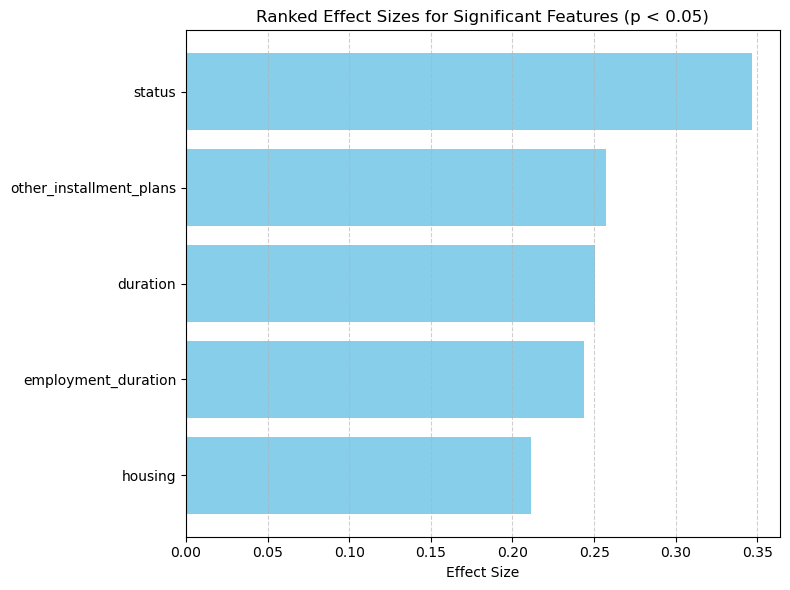

In [75]:
plt.figure(figsize=(8, 6))
plt.barh(eff_df['Feature'], eff_df['effect_size'], color='skyblue')
plt.xlabel("Effect Size")
plt.title("Ranked Effect Sizes for Significant Features (p < 0.05)")
plt.gca().invert_yaxis()  # largest effect at top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()